In [56]:
import numpy as np

## Data Engineering

Suppose we are given amino acid sequence s and class label sequence c. Let n be the length of both sequences. 
For simplicity, we assume there are 20 amino acids. We create a bijection mapping from each amino acid to [1, 20]. We map each amino acid sequence s to a n sized vector $s'\in R^n$, where the $i^{th}$ position is its corresponding numerical mapping from its amino acid.

In a similar fashion, we perform the same process for secondary structures. We assume there are two types of secondary structures alpha helix and beta sheet and optionally no secondary structure. We map each class label sequence c to a n sized vector $c' \in R^n$, where the $i^{th}$ position is its corresponding numerical mapping from its class label.

In [57]:
def aa_encode(s):
    amino_acids = list("AGILPVFWYDERHKSTCMNQ")
    amino_acids.sort()
    aa_mapping = {}
    for i, aa in enumerate(amino_acids):
        aa_mapping[aa] = i
    return list(map(lambda aa: aa_mapping[aa], list(s)))
        

def ss_encode(c):
    #TODO
    return list(map(lambda lbl: int(lbl) - 1, list(c)))


def aa_decode(s):
    amino_acids = list("AGILPVFWYDERHKSTCMNQ")
    amino_acids.sort()
    aa_mapping = {}
    for i, aa in enumerate(amino_acids):
        aa_mapping[i] = aa
    return list(map(lambda aa: aa_mapping[aa], list(s)))
    


## Model Parameterization

For notion, let $\theta$ := hidden markov model parameters (state transition probabilities, symbol emission probabilities), and let $\phi$ := class emission parameters.

Our objective function attempts to find maximize the conditionally probability of obtaining class label sequence c given amino acid sequence s, hidden markov parameters $\theta$, class emission parameters $\phi$.

The number of hidden states usually requires some expert insights. Here, we adopt the hidden markov model setup introduced in assignment two - which includes two hidden states A and B. Then, we have a 4 state transisition probabilities $(t_{aa}, t_{ab}, t_{ba}, t_{bb})$, 20 symbol emission probabilties for state A $(e_{a1}, ... , e_{a20})$, 20 symbol emission probabilties for state B $(e_{b1}, ... , e_{b20})$. Then, we have 44 parameters total for $\theta$.


In this setup, we also have 3 class emission probabilities for state A $(\phi_{a1}, \phi_{a2} , \phi_{a3})$, 3 class emission probabilities for state B $(\phi_{b1}, \phi_{b2} , \phi_{b3})$. 

For simplicity, we initalize these variables to a uniform distribution.

In [58]:
class HiddenMarkovModelParameters:
    
    
    def __init__(self, theta, phi=None):
        self.update_theta(theta)
        self.class_emiss_probs = np.ones((2, 3)) / 3
        if phi is None:
            self.phi = np.ones((2, 3)) / 3  # Uniform initialization if phi not provided
        else:
            self.update_phi(phi)
        
        
    def update_theta(self, new_theta):
        # Update transition probabilities
        self.trans_probs = np.array(new_theta[:4]).reshape(2, 2)

        # Update emission probabilities for state A and state B
        self.emiss_probs = np.zeros((2, 20))  # Assuming 20 emissions for each state
        self.emiss_probs[0, :] = new_theta[4:24]
        self.emiss_probs[1, :] = new_theta[24:] 
    
    
    def update_phi(self, new_phi):
        self.phi = np.array(new_phi).reshape(2, 3)
        
        
    def get_theta(self):
        return np.concatenate((self.trans_probs.flatten(), self.emiss_probs.flatten()))
    
    
    def get_phi(self):
        return self.phi.flatten()    

## Gradient Calculations / Class Emission Estimation / Class Prediction

#### We can convert our objective function into a minimization problem by changing our objective into minimizing the negative log likelihood.

$$\hat{\theta} = \arg \max_{\theta} P(c | s, \theta, \phi) = \frac{P(c, s | \theta, \phi)}{P(s | \theta)}$$
$$\hat{\theta} = \arg \min_{\theta} -\log(\frac{P(c, s | \theta, \phi)}{P(s | \theta)})$$

#### We can calculate the gradient of this expression into terms that we know from forward-backward algorithms.

$$\frac{dL}{d\theta_k} = -\frac {m_k(c, s) - n_k(s)}{\theta_k}$$

$$n_k(s) := \text{The expected number of times parameter k is used over all paths for a given observation sequence s}$$

$$m_k(c, s) := \text{The expected number of times parameter k is used in paths consistent with the observation sequence s and the class label sequence c}$$

#### In regards to class emission probabilitions, we attempt to maximize the following objective function.

$$\hat{\phi}_k = \arg \max_\phi P(c | s, \theta, \phi) = \arg \min_\phi - \log P(c, s | \theta, \phi)$$

$$\frac{dL}{d\phi_k} = \frac{-q_k(c, s)}{\phi_k}$$

$$q_k(s) := \text{The expected number of times a particular class emission parameter is used, given the observation sequence and class label sequence}$$

#### We can then calculate the most probable class labeling sequence via a variation of the Viterbi algorithm.

$$\hat{c} = \arg \max_c P(c | s, \theta, \phi)$$

In [59]:
class HiddenMarkovModel(HiddenMarkovModelParameters):
    
    
    def __init__(self, theta, phi=None):
        super().__init__(theta, phi)
    
    
    def log_sum_exp(self, arr):
        # Log-sum-exp trick for numerical stability in log-space
        max_val = np.max(arr)
        return max_val + np.log(np.sum(np.exp(arr - max_val)))
    
    
    def calculate_theta_gradient(self, mk, nk):
        if mk is None or nk is None:
            raise ValueError("mk and nk must be provided and have the correct shape.")

        theta_flat = np.concatenate((self.trans_probs.flatten(), self.emiss_probs.flatten()))
        theta_flat = np.clip(theta_flat, 1e-10, None)
        gradient = -(mk - nk) / theta_flat

        return gradient
    
    
    def calculate_phi_gradient(self, q_k):
        # Calculate gradient for phi using -q_k(c, s) / phi_k
        # Ensure no division by zero
        phi_k_nonzero = np.clip(self.phi, 1e-10, None)
        phi_gradient = -q_k / phi_k_nonzero
        return phi_gradient
    
    
    def forward_backward(self, obs, class_labels=None):
        num_states = 2
        num_observations = len(obs)

        forward = np.zeros((num_states, num_observations))
        backward = np.zeros((num_states, num_observations))
        n_k = np.zeros(4 + 2 * 20)  # Transition + Emission probabilities
        m_k = np.zeros_like(n_k)    # Expected usage of model parameters given class labels
        q_k = np.zeros((2, 3))      # Expected usage of class emission parameters

        num_paths = len(obs)**20

        # Forward Pass
        forward[:, 0] = self.emiss_probs[:, obs[0]] / num_states
        for t in range(1, num_observations):
            for s in range(num_states):
                forward[s, t] = 0
                for prev_s in range(num_states):
                    forward_prob = forward[prev_s, t-1] * self.trans_probs[prev_s, s] * self.emiss_probs[s, obs[t]]
                    forward[s, t] += forward_prob

                    # Update n_k for transition and emission probabilities
                    n_k_index = prev_s * num_states + s
                    # n_k[n_k_index] += forward_prob
                    # n_k[4 + s * 20 + obs[t]] += forward_prob

                    n_k[n_k_index] += 1.0
                    n_k[4 + s * 20 + obs[t]] += 1.0

                    # Update m_k if class_labels are provided
                    if class_labels is not None and class_labels[t] == s:
                        # m_k[n_k_index] += forward_prob
                        # m_k[4 + s * 20 + obs[t]] += forward_prob

                        m_k[n_k_index] += 1.0
                        m_k[4 + s * 20 + obs[t]] += 1.0

                # Update q_k for class emission probabilities
                if class_labels is not None:
                    # q_k[s, class_labels[t]] += forward[s, t]
                    q_k[s, class_labels[t]] += 1.0

        # Backward Pass
        backward[:, -1] = 1
        for t in range(num_observations - 2, -1, -1):
            for s in range(num_states):
                backward[s, t] = sum(backward[next_s, t+1] * self.trans_probs[s, next_s] * self.emiss_probs[next_s, obs[t+1]] for next_s in range(num_states))

        # Normalize n_k, m_k, and q_k by the total number of observations
        # n_k /= num_observations
        # m_k /= num_observations
        # q_k /= num_observations
                
        for i in range(len(n_k)):
            n_k[i] /= num_paths
        
        for i in range(len(m_k)):
            m_k[i] /= num_paths
        
        for i in range(len(q_k)):
            for j in range(len(q_k[i])):
                q_k[i][j] /= num_paths

        # Update class emission probabilities
        for state in range(num_states):
            self.phi[state] = q_k[state] / q_k[state].sum()

        return forward, backward, n_k, m_k, q_k
    
    
    def predict_class_sequence(self, obs_sequence):
        num_states = self.trans_probs.shape[0]
        num_observations = len(obs_sequence)

        # Initialize Viterbi matrices
        viterbi = np.zeros((num_states, num_observations))
        backpointer = np.zeros((num_states, num_observations), dtype=int)

        # Initialization step
        viterbi[:, 0] = self.emiss_probs[:, obs_sequence[0]] * self.phi[:, 0]

        # Viterbi algorithm - Dynamic Programming
        for t in range(1, num_observations):
            for s in range(num_states):
                transition_probs = viterbi[:, t-1] * self.trans_probs[:, s]
                max_prob = np.max(transition_probs)
                backpointer[s, t] = np.argmax(transition_probs)

                # Incorporate emission probabilities and class probabilities
                viterbi[s, t] = max_prob * self.emiss_probs[s, obs_sequence[t]] * self.phi[s, 0]

        # Backtracking to find the most probable path and class labels
        most_probable_path = np.zeros(num_observations, dtype=int)
        most_probable_classes = np.zeros(num_observations, dtype=int)
        most_probable_path[-1] = np.argmax(viterbi[:, -1])

        for t in range(num_observations - 2, -1, -1):
            most_probable_path[t] = backpointer[most_probable_path[t+1], t+1]
            most_probable_classes[t] = np.argmax(self.phi[most_probable_path[t], :])

        return most_probable_path, most_probable_classes    



## Gradient Descent

We use gradient descent to minimize our objective function.

We repeat the following operation until convergence. 

$\theta'=\theta - \alpha \nabla L$. 

For simplicity, we fix our step size $\alpha$.

In [60]:
class HiddenMarkovModelWithGradientDescent(HiddenMarkovModel):
    
    
    def __init__(self, theta, phi=None):
        super().__init__(theta, phi)
    
    
    def gradient_descent(self, observations_set, class_labels_set, learning_rate=0.01, iterations=100, convergence_threshold=1e-6):
        prev_theta = self.get_theta()
        prev_phi = self.phi.copy()

        for iteration in range(iterations):
            total_theta_gradient = np.zeros_like(prev_theta)
            total_phi_gradient = np.zeros_like(prev_phi)

            for obs, class_labels in zip(observations_set, class_labels_set):
                # Ensure the class label sequence matches the observation sequence in length
                if len(obs) != len(class_labels):
                    raise ValueError("Length of observation sequence and class label sequence must match.")

                _, _, nk, mk, q_k = self.forward_backward(obs, class_labels)
                theta_gradient = self.calculate_theta_gradient(mk, nk)
                phi_gradient = self.calculate_phi_gradient(q_k)

                total_theta_gradient += theta_gradient
                total_phi_gradient += phi_gradient

            # Average the gradients across all sequences
            avg_theta_gradient = total_theta_gradient / len(observations_set)
            avg_phi_gradient = total_phi_gradient / len(observations_set)

            # Update theta and phi in the direction of the negative average gradients
            updated_theta = prev_theta - learning_rate * avg_theta_gradient
            updated_phi = prev_phi - learning_rate * avg_phi_gradient

            # Constrain updated parameters
            updated_theta[:4] = np.clip(updated_theta[:4], 0, 1)
            updated_phi = np.clip(updated_phi, 0, 1)

            if np.linalg.norm(updated_theta - prev_theta) < convergence_threshold and \
               np.linalg.norm(updated_phi - prev_phi) < convergence_threshold:
                break

            prev_theta = updated_theta
            prev_phi = updated_phi

        self.update_theta(updated_theta)
        self.update_phi(updated_phi)
    
    def stochastic_gradient_descent(self, observations_set, class_labels_set, learning_rate=0.000001, iterations=10, batch_size=50, convergence_threshold=1e-6):
        prev_theta = self.get_theta()
        prev_phi = self.phi.copy()

        for iteration in range(iterations):
            shuffled_indices = np.random.permutation(len(observations_set))

            for i in range(0, len(shuffled_indices), batch_size):
                batch_indices = shuffled_indices[i:i + batch_size]
                total_theta_gradient = np.zeros_like(prev_theta)
                total_phi_gradient = np.zeros_like(prev_phi)

                for index in batch_indices:
                    obs, class_labels = observations_set[index], class_labels_set[index]
                    _, _, nk, mk, q_k = self.forward_backward(obs, class_labels)
                    theta_gradient = self.calculate_theta_gradient(mk, nk)
                    phi_gradient = self.calculate_phi_gradient(q_k)

                    total_theta_gradient += theta_gradient
                    total_phi_gradient += phi_gradient

                avg_theta_gradient = total_theta_gradient / len(batch_indices)
                avg_phi_gradient = total_phi_gradient / len(batch_indices)
                prev_theta -= learning_rate * avg_theta_gradient
                prev_phi -= learning_rate * avg_phi_gradient

                prev_theta[:4] = np.clip(prev_theta[:4], 0, 1)
                prev_phi = np.clip(prev_phi, 0, 1)

            if np.linalg.norm(self.get_theta() - prev_theta) < convergence_threshold and \
               np.linalg.norm(self.phi - prev_phi) < convergence_threshold:
                break

            self.update_theta(prev_theta)
            self.update_phi(prev_phi)



        

## ADAM

We use ADAM to optimize gradient descent by hypertuning our parameters.


In [61]:
class HiddenMarkovModelWithADAM(HiddenMarkovModel):
    
    def __init__(self, theta, phi=None):
        super().__init__(theta, phi)
      
    def adam(self, observations_set, class_labels_set, learning_rate=0.01, iterations=5, convergence_threshold=1e-6, beta1=0.9, beta2=0.99):
        prev_theta = self.get_theta()
        prev_phi = self.phi.copy()

        theta_m = np.zeros_like(prev_theta)
        theta_rms = np.zeros_like(prev_theta)
        phi_m = np.zeros_like(prev_phi)
        phi_rms = np.zeros_like(prev_phi)

        for iteration in range(iterations):
            total_theta_gradient = np.zeros_like(prev_theta)
            total_phi_gradient = np.zeros_like(prev_phi)

            for obs, class_labels in zip(observations_set, class_labels_set):
                _, _, nk, mk, q_k = self.forward_backward(obs, class_labels)
                theta_gradient = self.calculate_theta_gradient(mk, nk)
                phi_gradient = self.calculate_phi_gradient(q_k)

                total_theta_gradient += theta_gradient
                total_phi_gradient += phi_gradient

            # Update Parameters using ADAM
            theta_m = beta1 * theta_m + (1 - beta1) * total_theta_gradient
            theta_rms = beta2 * theta_rms + (1 - beta2) * (total_theta_gradient ** 2)
            phi_m = beta1 * phi_m + (1 - beta1) * total_phi_gradient
            phi_rms = beta2 * phi_rms + (1 - beta2) * (total_phi_gradient ** 2)

            # Bias Correction
            theta_m_corrected = theta_m / (1 - beta1 ** (iteration + 1))
            theta_rms_corrected = theta_rms / (1 - beta2 ** (iteration + 1) + 1e-8)
            phi_m_corrected = phi_m / (1 - beta1 ** (iteration + 1) + 1e-8)
            phi_rms_corrected = phi_rms / (1 - beta2 ** (iteration + 1) + 1e-8)

            updated_theta = prev_theta - learning_rate * theta_m_corrected / (np.sqrt(theta_rms_corrected) + 1e-8)
            updated_phi = prev_phi - learning_rate * phi_m_corrected / (np.sqrt(phi_rms_corrected) + 1e-8)

            # Constrain updated parameters
            updated_theta[:4] = np.clip(updated_theta[:4], 0, 1)
            updated_phi = np.clip(updated_phi, 0, 1)

            if np.linalg.norm(updated_theta - prev_theta) < convergence_threshold and \
               np.linalg.norm(updated_phi - prev_phi) < convergence_threshold:
                break

            prev_theta = updated_theta
            prev_phi = updated_phi

        self.update_theta(updated_theta)
        self.update_phi(updated_phi)


## Workflow on Human Data

Since our dataset if limited, we approximate our validation error using k-cross-folds validation in particular we use LOOCV (leave-one-out-cross-validation). 


In [62]:
def calculate_accuracy(actual, predicted):
    if len(actual) != len(predicted):
        raise ValueError("The lengths of the actual and predicted sequences must match.")
    matches = sum(a == p for a, p in zip(actual, predicted))
    return matches / len(actual)

with open("HUMAN_training_data.txt") as f:
    content = f.read().split("\n")
    observations_set = [aa_encode(content[i]) for i in range(0, len(content), 2)]
    class_labels_set = [ss_encode(content[i]) for i in range(1, len(content), 2)]

    
# Initialize parameters
transition_probs = [0.5, 0.5, 0.5, 0.5]
emission_probs = [1.0 / 20] * 40
theta_initial = transition_probs + emission_probs
phi_initial = [[1.0 / 3] * 3, [1.0 / 3] * 3]

# Variables to store results
accuracies = []

# Leave-One-Out Cross-Validation
for i in range(1, len(observations_set)):
    # Prepare training and test sets
    training_observations = observations_set[:i] + observations_set[i+1:]
    training_labels = class_labels_set[:i] + class_labels_set[i+1:]
    test_observation = observations_set[i]
    test_label = class_labels_set[i]

    # Initialize and train the model
    hmm = HiddenMarkovModelWithGradientDescent(theta_initial, phi_initial)
    hmm.gradient_descent(training_observations, training_labels)

    # Predict class sequence for the test observation
    _, predicted_class_sequence = hmm.predict_class_sequence(test_observation)

    # Calculate and store accuracy
    accuracy = calculate_accuracy(test_label, predicted_class_sequence)
    accuracies.append(accuracy)

# Calculate average accuracy
HUMAN_ACCURACY_ESTIMATE = sum(accuracies) / len(accuracies)
print(f"Average Accuracy: {HUMAN_ACCURACY_ESTIMATE:.3f}")


## Workflow on Rat Data

We perform similarly on a rat dataset.

In [ ]:
def calculate_accuracy(actual, predicted):
    if len(actual) != len(predicted):
        raise ValueError("The lengths of the actual and predicted sequences must match.")
    matches = sum(a == p for a, p in zip(actual, predicted))
    return matches / len(actual)

with open("RAT_training_data.txt") as f:
    content = f.read().split("\n")
    observations_set = [aa_encode(content[i]) for i in range(0, len(content), 2)]
    class_labels_set = [ss_encode(content[i]) for i in range(1, len(content), 2)]

    
# Initialize parameters
transition_probs = [0.5, 0.5, 0.5, 0.5]
emission_probs = [1.0 / 20] * 40
theta_initial = transition_probs + emission_probs
phi_initial = [[1.0 / 3] * 3, [1.0 / 3] * 3]

# Variables to store results
accuracies = []

# Leave-One-Out Cross-Validation
for i in range(1, len(observations_set)):
    # Prepare training and test sets
    training_observations = observations_set[:i] + observations_set[i+1:]
    training_labels = class_labels_set[:i] + class_labels_set[i+1:]
    test_observation = observations_set[i]
    test_label = class_labels_set[i]

    # Initialize and train the model
    hmm = HiddenMarkovModelWithGradientDescent(theta_initial, phi_initial)
    hmm.gradient_descent(training_observations, training_labels)

    # Predict class sequence for the test observation
    _, predicted_class_sequence = hmm.predict_class_sequence(test_observation)

    # Calculate and store accuracy
    accuracy = calculate_accuracy(test_label, predicted_class_sequence)
    accuracies.append(accuracy)

# Calculate average accuracy
RAT_ACCURACY_ESTIMATE = sum(accuracies) / len(accuracies)
print(f"Average Accuracy: {RAT_ACCURACY_ESTIMATE:.3f}")

/var/folders/c6/zqf1hzkx6_x2vfd2bph00qyr0000gn/T/ipykernel_48661/3660622548.py:48: RuntimeWarning: divide by zero encountered in scalar divide
  theta_m_corrected[i] = theta_m[i] / (1 - beta1**iteration)
/var/folders/c6/zqf1hzkx6_x2vfd2bph00qyr0000gn/T/ipykernel_48661/3660622548.py:49: RuntimeWarning: divide by zero encountered in scalar divide
  theta_rms_corrected[i] = theta_rms[i] / (1 - beta2**iteration)
/var/folders/c6/zqf1hzkx6_x2vfd2bph00qyr0000gn/T/ipykernel_48661/3660622548.py:57: RuntimeWarning: divide by zero encountered in divide
  phi_m_corrected[i] = phi_m[i] / (1 - beta1**iteration)
/var/folders/c6/zqf1hzkx6_x2vfd2bph00qyr0000gn/T/ipykernel_48661/3660622548.py:58: RuntimeWarning: divide by zero encountered in divide
  phi_rms_corrected[i] = phi_rms[i] / (1 - beta2**iteration)
/var/folders/c6/zqf1hzkx6_x2vfd2bph00qyr0000gn/T/ipykernel_48661/3660622548.py:67: RuntimeWarning: invalid value encountered in divide
  updated_theta = prev_theta - learning_rate * theta_m_correcte

Average Accuracy: 0.495


## Results

Since our dataset is small and our objective function is highly non-convex, we see that this approach produces subpar approach against baseline guessing. 


#### Random guessing accuracy
$$a := \text{the percentage of matching pairs against a prediction and true label}$$
$$p_{ai} := \text{probability of randomly selecting the correct secondary structure at position i} = 3$$
$$E[a] = E[\sum_{i=0}^{n-1}(1)(p_{ai})]=\sum_{i=0}^{n-1}E[a_i]=\frac{1}{3}n$$

$$\frac{\frac{n}{3}}{n}=\frac{1}{3}$$

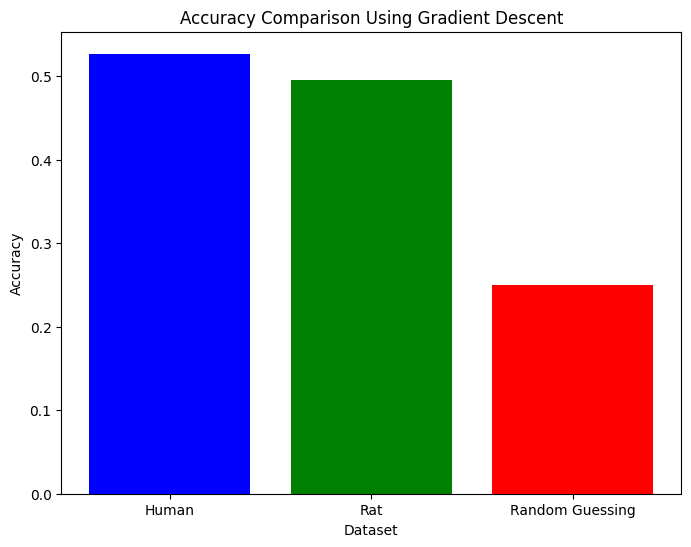

In [ ]:
import matplotlib.pyplot as plt

# Accuracy estimates
RANDOM_GUESSING_ESTIMATE = 0.25 # Assuming random guessing in a three-class problem

# Data for plotting
labels = ['Human', 'Rat', 'Random Guessing']
accuracy_values = [HUMAN_ACCURACY_ESTIMATE, RAT_ACCURACY_ESTIMATE, RANDOM_GUESSING_ESTIMATE]

# Creating the bar chart
plt.figure(figsize=(8, 6))
plt.bar(labels, accuracy_values, color=['blue', 'green', 'red'])

# Adding titles and labels
plt.title('Accuracy Comparison Using Gradient Descent')
plt.ylabel('Accuracy')
plt.xlabel('Dataset')

# Show the plot
plt.show()